# Imports and plotting setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.xkcd()
plt.rcParams['font.family'] = "xkcd"

We have a bunch of different headers in our CSVs for the different memory measurements per-GPU

In [3]:
gpu_headers = []
for gpu in range(8):
    gpu_headers.append(f"Allocated MiB cuda{gpu}")
    gpu_headers.append(f"Reserved MiB cuda{gpu}")


# No optimizer offload

## No optimizer offload, no expandable segments

This is the first measurementI took

In [4]:
without_df = pd.read_csv(
    'initial-results-no-env-var.csv', 
    header=None,
    names=['Sequence length'] + gpu_headers + ['Iterations/second']
)
without_df.head(24)

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,Reserved MiB cuda4,Allocated MiB cuda5,Reserved MiB cuda5,Allocated MiB cuda6,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second
0,1,0,0,0,0,0,0,34593,44008,0,0,0,0,0,0,0,0,1.547439
1,1,34705,43896,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.547532
2,1,0,0,0,0,33377,43896,0,0,0,0,0,0,0,0,0,0,1.547443
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33265,43896,1.547509
4,1,0,0,0,0,0,0,0,0,0,0,34369,43896,0,0,0,0,1.547480
5,1,0,0,0,0,0,0,0,0,0,0,0,0,33153,43896,0,0,1.547678
6,1,0,0,0,0,0,0,0,0,33153,43896,0,0,0,0,0,0,1.547379
7,1,0,0,34481,44008,0,0,0,0,0,0,0,0,0,0,0,0,1.547445
8,11,0,0,0,0,34848,46970,0,0,0,0,0,0,0,0,0,0,1.252515
9,11,34848,46970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.252508


Because each process for a given sequence length wrote out a line for the GPU it was using, we should have one line per GPU for each sequence length.  Let's confirm that.
                                                

In [5]:
def validate_gpu_allocation(df):
    issues = []
    sequence_lengths = df['Sequence length'].unique()
    
    for seq_length in sequence_lengths:
        group = df[df['Sequence length'] == seq_length]
        
        if len(group) != 8:
            issues.append(f"Sequence length {seq_length}: Expected 8 rows, but found {len(group)}")
            continue
        
        active_gpu_set = set()
        for i, row in group.iterrows():
            active_gpus = [(j, row[f'Allocated MiB cuda{j}']) for j in range(8) if row[f'Allocated MiB cuda{j}'] != 0]
            
            if len(active_gpus) != 1:
                issues.append(f"Sequence length {seq_length}, Row {i}: Has {len(active_gpus)} active GPUs, expected 1")
            else:
                gpu_num = active_gpus[0][0]
                if gpu_num in active_gpu_set:
                    issues.append(f"Sequence length {seq_length}: GPU {gpu_num} is active in multiple rows")
                active_gpu_set.add(gpu_num)
        
        if len(active_gpu_set) != 8:
            missing_gpus = set(range(8)) - active_gpu_set
            issues.append(f"Sequence length {seq_length}: Missing data for GPUs {missing_gpus}")
    
    if not issues:
        print("All rows validated OK")
    else:
        print("Validation issues found:")
        for issue in issues:
            print(f"- {issue}")
    
    print(f"Total sequence lengths checked: {len(sequence_lengths)}")

# Use the function
validate_gpu_allocation(without_df)

All rows validated OK
Total sequence lengths checked: 25


Because we know that we have data that makes sense, let's consolidate things so that we have one line per sequence length

In [6]:
def normalize_gpu_data(df):
    # Group by sequence length
    grouped = df.groupby('Sequence length')
    
    normalized_data = []
    
    for seq_length, group in grouped:
        new_row = {'Sequence length': seq_length}
        
        # Combine GPU data
        for gpu in range(8):
            allocated = group[f'Allocated MiB cuda{gpu}'].max()
            reserved = group[f'Reserved MiB cuda{gpu}'].max()
            new_row[f'Allocated MiB cuda{gpu}'] = allocated
            new_row[f'Reserved MiB cuda{gpu}'] = reserved
        
        # Average iterations/second
        new_row['Iterations/second'] = group['Iterations/second'].mean()
        
        normalized_data.append(new_row)
    
    # Create new DataFrame
    normalized_df = pd.DataFrame(normalized_data)
    
    # Ensure columns are in the same order as the original DataFrame
    normalized_df = normalized_df[df.columns]
    
    return normalized_df

# Use the function
normalized_without_df = normalize_gpu_data(without_df)

# Display the first few rows of the normalized DataFrame
normalized_without_df.head(24)

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,Reserved MiB cuda4,Allocated MiB cuda5,Reserved MiB cuda5,Allocated MiB cuda6,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second
0,1,34705,43896,34481,44008,33377,43896,34593,44008,33153,43896,34369,43896,33153,43896,33265,43896,1.547488
1,11,34848,46970,33104,44966,34848,46970,34667,46970,34603,46970,33362,44966,34829,46970,34592,46970,1.252463
2,21,34827,46038,33166,45036,34827,45036,34827,46038,34827,46038,34827,45036,34827,46038,34827,46150,1.593840
3,31,33118,46108,36761,47446,36761,47334,36761,47414,36761,47446,36761,46332,36761,47446,32628,45106,1.267743
4,41,34951,45030,34583,45030,34951,45030,34951,45030,32879,45030,34727,45030,34951,45030,34951,45030,1.586931
5,141,34043,44914,34182,44914,35343,44914,35343,44914,35455,44914,35455,44914,35343,44914,35343,44914,1.585541
6,241,36190,44932,36187,44932,36187,44932,36190,44932,36245,45044,34881,44932,34814,44932,34788,44932,1.575950
7,341,34661,44952,37370,46956,36777,47068,35281,44952,36834,46956,36922,47068,36546,47068,36553,46956,1.243988
8,441,37399,47900,37064,47564,37399,47900,37024,47452,37399,47788,37399,47900,37400,47564,37399,47676,1.577641
9,541,38003,48554,38003,48554,38003,48218,38003,48218,36936,48106,37874,48218,38003,48218,36954,48106,1.577131


Now let's add max, min and mean numbers to each sequence length for both reserved and allocated memory so that we can plot some averages.

In [7]:
def add_gpu_summary_stats(df):
    # Calculate min, mean, and max for Allocated and Reserved MiB across all GPUs
    for metric in ['Allocated', 'Reserved']:
        # Get all columns for this metric
        cols = [col for col in df.columns if col.startswith(f'{metric} MiB cuda')]
        
        # Calculate min, mean, and max
        df[f'{metric} MiB Min'] = df[cols].min(axis=1)
        df[f'{metric} MiB Mean'] = df[cols].mean(axis=1)
        df[f'{metric} MiB Max'] = df[cols].max(axis=1)
    
    return df

# Use both functions in sequence
normalized_without_df = add_gpu_summary_stats(normalized_without_df)

# Display the first few rows of the final DataFrame
print(normalized_without_df.head())

# Print the shape of the new DataFrame
print(f"\nShape of final DataFrame: {normalized_without_df.shape}")

# Print the names of the new columns
new_columns = ['Allocated MiB Min', 'Allocated MiB Mean', 'Allocated MiB Max',
               'Reserved MiB Min', 'Reserved MiB Mean', 'Reserved MiB Max']
print("\nNew columns added:")
for col in new_columns:
    print(f"- {col}")

   Sequence length  Allocated MiB cuda0  Reserved MiB cuda0  \
0                1                34705               43896   
1               11                34848               46970   
2               21                34827               46038   
3               31                33118               46108   
4               41                34951               45030   

   Allocated MiB cuda1  Reserved MiB cuda1  Allocated MiB cuda2  \
0                34481               44008                33377   
1                33104               44966                34848   
2                33166               45036                34827   
3                36761               47446                36761   
4                34583               45030                34951   

   Reserved MiB cuda2  Allocated MiB cuda3  Reserved MiB cuda3  \
0               43896                34593               44008   
1               46970                34667               46970   
2               4503

Finally, let's plot everything.

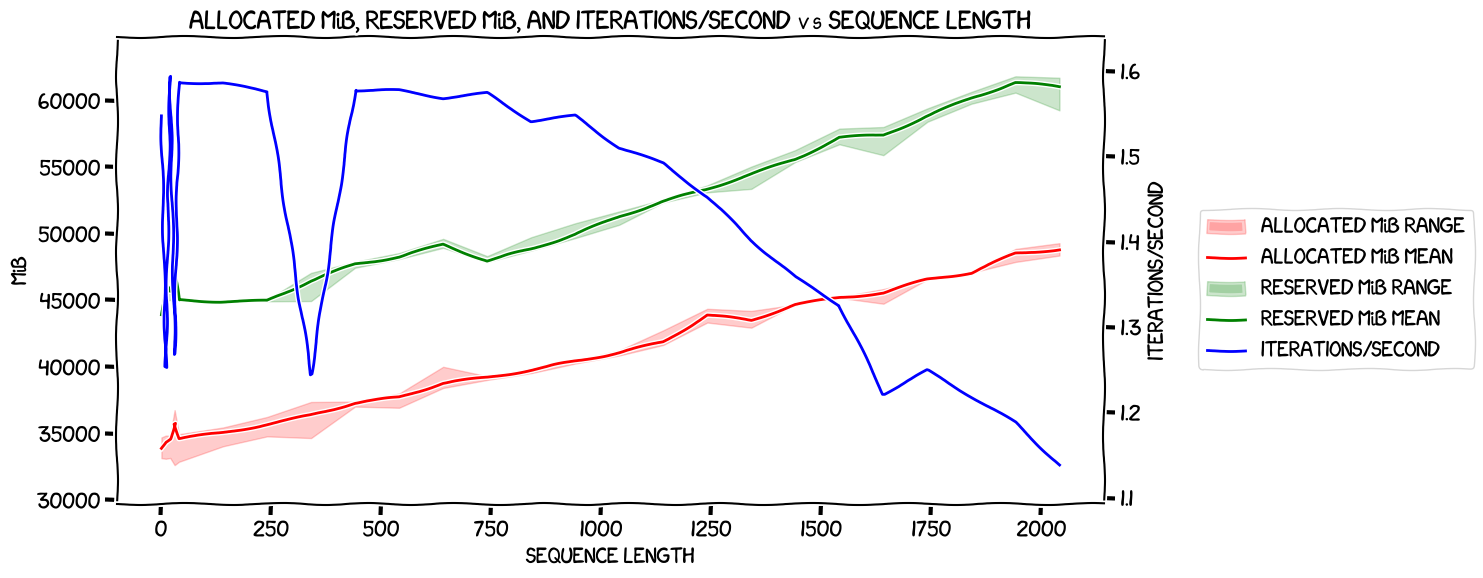

In [8]:
import matplotlib.pyplot as plt

def plot(df):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Allocated MiB
    ax1.fill_between(df['Sequence length'], df['Allocated MiB Min'], df['Allocated MiB Max'], alpha=0.2, color='red', label='ALLOCATED MiB RANGE')
    ax1.plot(df['Sequence length'], df['Allocated MiB Mean'], label='ALLOCATED MiB MEAN', color='red', linewidth=2)

    # Plot Reserved MiB
    ax1.fill_between(df['Sequence length'], df['Reserved MiB Min'], df['Reserved MiB Max'], alpha=0.2, color='green', label='RESERVED MiB RANGE')
    ax1.plot(df['Sequence length'], df['Reserved MiB Mean'], label='RESERVED MiB MEAN', color='green', linewidth=2)

    ax1.set_xlabel('SEQUENCE LENGTH')
    ax1.set_ylabel('MiB')
    ax1.tick_params(axis='y')
    
    # Adjust y-axis limits based on data
    y_min = min(df['Allocated MiB Min'].min(), df['Reserved MiB Min'].min())
    y_max = max(df['Allocated MiB Max'].max(), df['Reserved MiB Max'].max())
    y_range = y_max - y_min
    ax1.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

    ax2 = ax1.twinx()
    ax2.plot(df['Sequence length'], df['Iterations/second'], label='ITERATIONS/SECOND', color='blue', linewidth=2)
    ax2.set_ylabel('ITERATIONS/SECOND')
    ax2.tick_params(axis='y')
    
    # Adjust y-axis limits for iterations/second
    iter_min, iter_max = df['Iterations/second'].min(), df['Iterations/second'].max()
    iter_range = iter_max - iter_min
    ax2.set_ylim(iter_min - 0.1*iter_range, iter_max + 0.1*iter_range)

    plt.title('ALLOCATED MiB, RESERVED MiB, AND ITERATIONS/SECOND vs SEQUENCE LENGTH')
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    return fig

# Use the function
fig = plot(normalized_without_df)
plt.savefig("/tmp/sequence-length-vs-vram-and-speed-8b-no-expandable-segments-no-offload.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

## No optimizer offload, but with expandable segments

Same steps but with a different CSV

In [9]:
with_df = pd.read_csv(
    'results-with-env-var.csv', 
    header=None,
    names=['Sequence length'] + gpu_headers + ['Iterations/second']
)
with_df.head(24)

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,Reserved MiB cuda4,Allocated MiB cuda5,Reserved MiB cuda5,Allocated MiB cuda6,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second
0,1,0,0,0,0,0,0,36590,44234,0,0,0,0,0,0,0,0,1.577822
1,1,0,0,0,0,0,0,0,0,36590,44254,0,0,0,0,0,0,1.577523
2,1,36590,44254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.577682
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36590,44234,1.577606
4,1,0,0,0,0,0,0,0,0,0,0,0,0,36590,44234,0,0,1.577581
5,1,0,0,0,0,33263,42854,0,0,0,0,0,0,0,0,0,0,1.577649
6,1,0,0,0,0,0,0,0,0,0,0,36590,44234,0,0,0,0,1.577620
7,1,0,0,36590,44234,0,0,0,0,0,0,0,0,0,0,0,0,1.577525
8,101,0,0,0,0,35541,43988,0,0,0,0,0,0,0,0,0,0,1.566649
9,101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35507,43828,1.566546


In [10]:
validate_gpu_allocation(with_df)

All rows validated OK
Total sequence lengths checked: 21


In [11]:
normalized_with_df = normalize_gpu_data(with_df)

# Display the first few rows of the normalized DataFrame
normalized_with_df.head(24)

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,Reserved MiB cuda4,Allocated MiB cuda5,Reserved MiB cuda5,Allocated MiB cuda6,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second
0,1,36590,44254,36590,44234,33263,42854,36590,44234,36590,44254,36590,44234,36590,44234,36590,44234,1.577626
1,101,33777,43408,35086,43748,35541,43988,35310,43728,33918,43728,33885,43488,35310,43768,35507,43828,1.566576
2,201,35395,43540,35982,43940,35926,43880,35917,43640,35693,43800,35396,43660,34294,43260,35396,43440,1.253252
3,301,36530,43498,36306,43778,36301,43298,36306,43378,34908,43258,36530,43578,35132,43398,36525,43578,1.591545
4,401,37141,45858,37141,45978,35905,45318,37141,45518,36908,45138,35916,45138,37141,45998,36725,45438,1.550960
5,501,37642,43800,37642,43820,37642,43880,37530,44660,37515,43860,37642,44680,36665,43820,36567,44380,1.576724
6,601,38440,47482,38368,47102,38256,47102,38032,46682,38347,47102,38347,47102,38368,47462,38000,46442,1.555553
7,701,38614,45254,38982,45334,39249,45574,38870,45134,38982,44994,38982,45654,38982,45074,38000,44874,1.576324
8,801,41114,46944,41114,46804,41135,46944,41114,46764,41114,46724,41114,46824,41114,46784,39262,45904,1.555781
9,901,39831,46006,42795,49006,42795,49006,42795,49086,42795,48986,42795,49006,39991,45886,42795,49006,1.260989


In [12]:
normalized_with_df = add_gpu_summary_stats(normalized_with_df)
normalized_with_df

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,...,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second,Allocated MiB Min,Allocated MiB Mean,Allocated MiB Max,Reserved MiB Min,Reserved MiB Mean,Reserved MiB Max
0,1,36590,44254,36590,44234,33263,42854,36590,44234,36590,...,44234,36590,44234,1.577626,33263,36174.125,36590,42854,44066.5,44254
1,101,33777,43408,35086,43748,35541,43988,35310,43728,33918,...,43768,35507,43828,1.566576,33777,34791.750,35541,43408,43710.5,43988
2,201,35395,43540,35982,43940,35926,43880,35917,43640,35693,...,43260,35396,43440,1.253252,34294,35499.875,35982,43260,43645.0,43940
3,301,36530,43498,36306,43778,36301,43298,36306,43378,34908,...,43398,36525,43578,1.591545,34908,36067.250,36530,43258,43470.5,43778
4,401,37141,45858,37141,45978,35905,45318,37141,45518,36908,...,45998,36725,45438,1.550960,35905,36752.250,37141,45138,45548.0,45998
5,501,37642,43800,37642,43820,37642,43880,37530,44660,37515,...,43820,36567,44380,1.576724,36567,37355.625,37642,43800,44112.5,44680
6,601,38440,47482,38368,47102,38256,47102,38032,46682,38347,...,47462,38000,46442,1.555553,38000,38269.750,38440,46442,47059.5,47482
7,701,38614,45254,38982,45334,39249,45574,38870,45134,38982,...,45074,38000,44874,1.576324,38000,38832.625,39249,44874,45236.5,45654
8,801,41114,46944,41114,46804,41135,46944,41114,46764,41114,...,46784,39262,45904,1.555781,39262,40885.125,41135,45904,46711.5,46944
9,901,39831,46006,42795,49006,42795,49006,42795,49086,42795,...,45886,42795,49006,1.260989,39831,42074.000,42795,45886,48248.5,49086


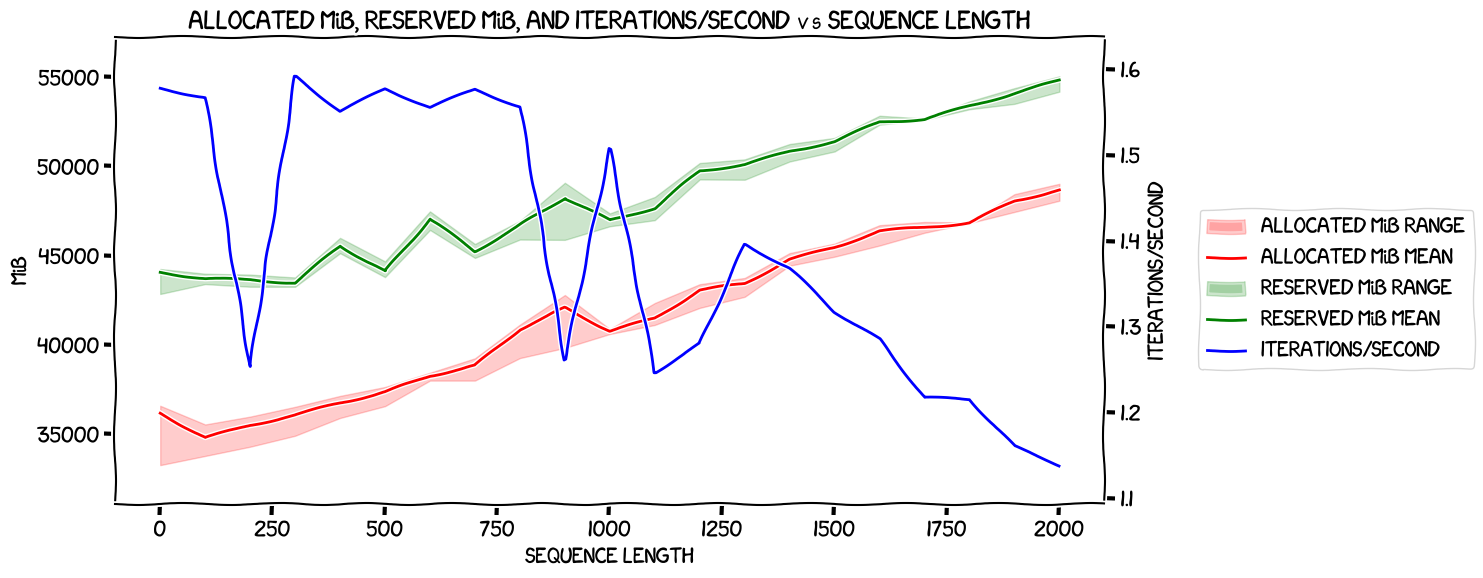

In [13]:
fig = plot(normalized_with_df)
plt.savefig("/tmp/sequence-length-vs-vram-and-speed-8b-with-expandable-segments-no-offload.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

# Comparison of runs with no optimizer offload, with and without expandable segments

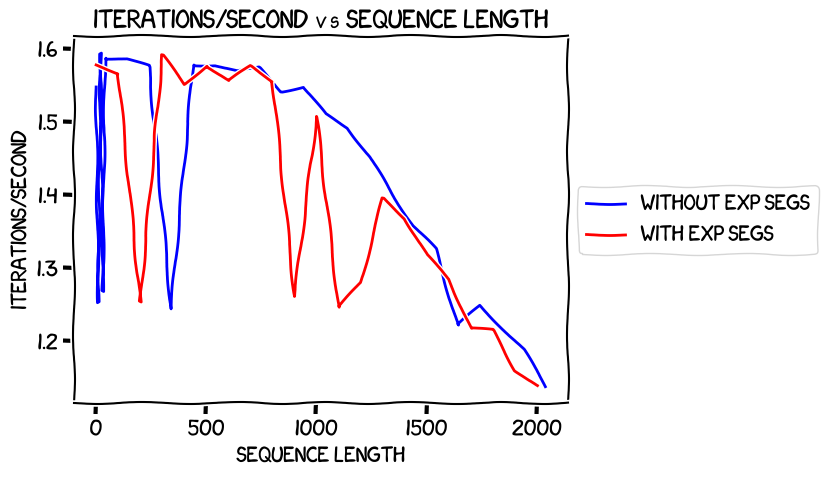

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot iterations/second from both dataframes
ax.plot(normalized_without_df['Sequence length'], normalized_without_df['Iterations/second'], 
        label='WITHOUT EXP SEGS', color='blue')
ax.plot(normalized_with_df['Sequence length'], normalized_with_df['Iterations/second'], 
        label='WITH EXP SEGS', color='red')

# Set labels and title
ax.set_xlabel('SEQUENCE LENGTH')
ax.set_ylabel('ITERATIONS/SECOND')
ax.set_title('ITERATIONS/SECOND vs SEQUENCE LENGTH')

# Add legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to accommodate legend
plt.savefig("/tmp/sequence-length-vs-iterations-per-second-no-offload-comparison.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

A bit surprised about how much the abvove shows issues caused by expandable segments.  Maybe noise in the data?

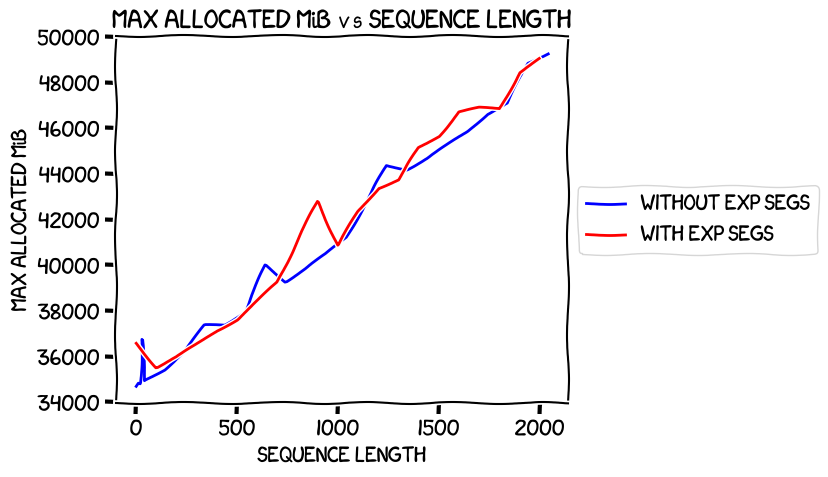

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(normalized_without_df['Sequence length'], normalized_without_df['Allocated MiB Max'], 
        label='WITHOUT EXP SEGS', color='blue')
ax.plot(normalized_with_df['Sequence length'], normalized_with_df['Allocated MiB Max'], 
        label='WITH EXP SEGS', color='red')

ax.set_xlabel('SEQUENCE LENGTH')
ax.set_ylabel('MAX ALLOCATED MiB')
ax.set_title('MAX ALLOCATED MiB vs SEQUENCE LENGTH')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to accommodate legend
plt.savefig("/tmp/sequence-length-vs-allocated-comparison-no-offload.png", bbox_inches='tight')
plt.show()

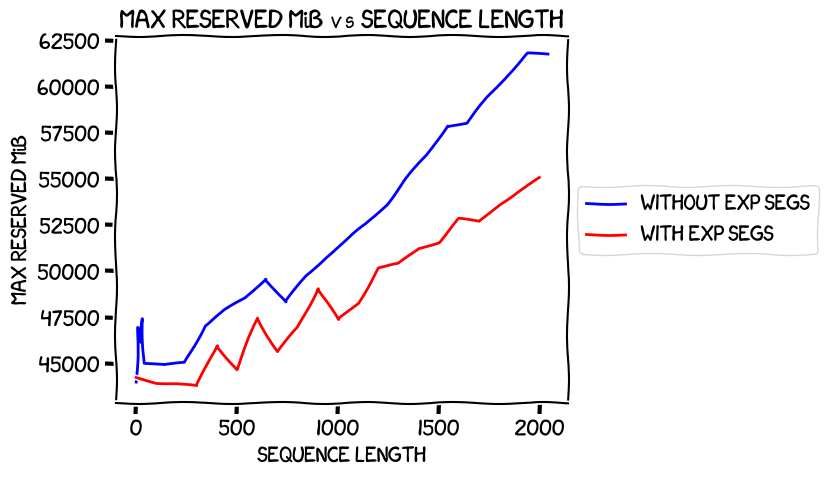

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(normalized_without_df['Sequence length'], normalized_without_df['Reserved MiB Max'], 
        label='WITHOUT EXP SEGS', color='blue')
ax.plot(normalized_with_df['Sequence length'], normalized_with_df['Reserved MiB Max'], 
        label='WITH EXP SEGS', color='red')

ax.set_xlabel('SEQUENCE LENGTH')
ax.set_ylabel('MAX RESERVED MiB')
ax.set_title('MAX RESERVED MiB vs SEQUENCE LENGTH')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to accommodate legend
plt.savefig("/tmp/sequence-length-vs-reserved-comparison-no-offload.png", bbox_inches='tight')
plt.show()

# With optimizer offload

## With optimizer offload, no expandable segments

In [17]:
without_and_optimizer_offload_df = pd.read_csv(
    'results-with-no-env-var-but-with-optimizer-offload.csv', 
    header=None,
    names=['Sequence length'] + gpu_headers + ['Iterations/second']
)
with_df.head(24)

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,Reserved MiB cuda4,Allocated MiB cuda5,Reserved MiB cuda5,Allocated MiB cuda6,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second
0,1,0,0,0,0,0,0,36590,44234,0,0,0,0,0,0,0,0,1.577822
1,1,0,0,0,0,0,0,0,0,36590,44254,0,0,0,0,0,0,1.577523
2,1,36590,44254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.577682
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36590,44234,1.577606
4,1,0,0,0,0,0,0,0,0,0,0,0,0,36590,44234,0,0,1.577581
5,1,0,0,0,0,33263,42854,0,0,0,0,0,0,0,0,0,0,1.577649
6,1,0,0,0,0,0,0,0,0,0,0,36590,44234,0,0,0,0,1.577620
7,1,0,0,36590,44234,0,0,0,0,0,0,0,0,0,0,0,0,1.577525
8,101,0,0,0,0,35541,43988,0,0,0,0,0,0,0,0,0,0,1.566649
9,101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35507,43828,1.566546


In [18]:
validate_gpu_allocation(without_and_optimizer_offload_df)

All rows validated OK
Total sequence lengths checked: 21


In [19]:
normalized_without_and_optimizer_offload_df = normalize_gpu_data(without_and_optimizer_offload_df)

# Display the first few rows of the normalized DataFrame
normalized_without_and_optimizer_offload_df.head(24)

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,Reserved MiB cuda4,Allocated MiB cuda5,Reserved MiB cuda5,Allocated MiB cuda6,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second
0,1,23929,26934,20419,24752,20419,24752,20419,24752,20419,24752,20897,24752,20292,25350,23930,24930,0.210409
1,101,23929,27154,20465,24972,20465,24972,20465,24972,20465,24972,20927,25420,20292,25570,23957,25150,0.327024
2,201,23929,27282,20512,25100,20512,25100,20512,25100,20512,25100,20958,25548,20292,25698,23985,25278,0.295290
3,301,23930,27344,20559,25162,20558,25162,20559,25162,20559,25162,20988,25610,20293,25634,24013,25452,0.306215
4,401,23929,27518,20605,25336,20605,25336,20605,25336,20605,25336,21018,25784,20292,25808,24042,25626,0.317103
5,501,23929,27690,20652,25508,20652,25508,20652,25508,20652,25508,21049,25508,20299,25980,24070,25798,0.297356
6,601,23929,27910,20695,25728,20695,25728,20695,25728,20695,25728,21077,25728,20336,26200,24094,26018,0.285385
7,701,23929,28088,20744,25906,20744,25906,20744,25906,20744,25906,21107,25906,20378,26378,24122,26196,0.305704
8,801,23929,28262,20788,26080,20788,26080,20788,26080,20788,26080,21138,26080,20419,26552,24150,26370,0.306477
9,901,23929,28450,20835,26268,20835,26268,20835,26268,20835,26268,21169,26268,20461,26740,24178,26558,0.300892


In [20]:
normalized_without_and_optimizer_offload_df = add_gpu_summary_stats(normalized_without_and_optimizer_offload_df)
normalized_without_and_optimizer_offload_df

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,...,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second,Allocated MiB Min,Allocated MiB Mean,Allocated MiB Max,Reserved MiB Min,Reserved MiB Mean,Reserved MiB Max
0,1,23929,26934,20419,24752,20419,24752,20419,24752,20419,...,25350,23930,24930,0.210409,20292,21340.500,23930,24752,25121.75,26934
1,101,23929,27154,20465,24972,20465,24972,20465,24972,20465,...,25570,23957,25150,0.327024,20292,21370.625,23957,24972,25397.75,27154
2,201,23929,27282,20512,25100,20512,25100,20512,25100,20512,...,25698,23985,25278,0.295290,20292,21401.500,23985,25100,25525.75,27282
3,301,23930,27344,20559,25162,20558,25162,20559,25162,20559,...,25634,24013,25452,0.306215,20293,21432.375,24013,25162,25586.00,27344
4,401,23929,27518,20605,25336,20605,25336,20605,25336,20605,...,25808,24042,25626,0.317103,20292,21462.625,24042,25336,25760.00,27518
5,501,23929,27690,20652,25508,20652,25508,20652,25508,20652,...,25980,24070,25798,0.297356,20299,21494.375,24070,25508,25876.00,27690
6,601,23929,27910,20695,25728,20695,25728,20695,25728,20695,...,26200,24094,26018,0.285385,20336,21527.000,24094,25728,26096.00,27910
7,701,23929,28088,20744,25906,20744,25906,20744,25906,20744,...,26378,24122,26196,0.305704,20378,21564.000,24122,25906,26274.00,28088
8,801,23929,28262,20788,26080,20788,26080,20788,26080,20788,...,26552,24150,26370,0.306477,20419,21598.500,24150,26080,26448.00,28262
9,901,23929,28450,20835,26268,20835,26268,20835,26268,20835,...,26740,24178,26558,0.300892,20461,21634.625,24178,26268,26636.00,28450


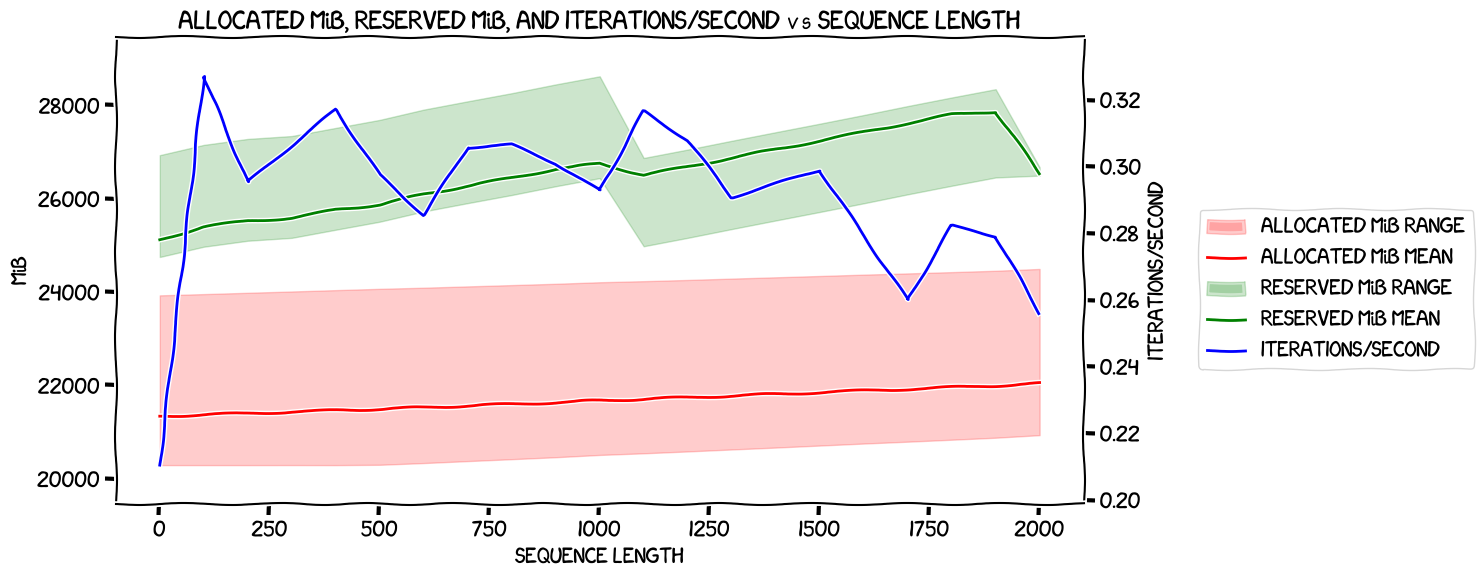

In [21]:
fig = plot(normalized_without_and_optimizer_offload_df)
plt.savefig("/tmp/sequence-length-vs-vram-and-speed-8b-no-expandable-segments-with-optimizer-offload.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

Much wider bands for both types of memory!

## With optimizer offload, with expandable segments

In [22]:
with_and_optimizer_offload_df = pd.read_csv(
    'results-with-env-var-with-optimizer-offload.csv', 
    header=None,
    names=['Sequence length'] + gpu_headers + ['Iterations/second']
)
with_df.head(24)

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,Reserved MiB cuda4,Allocated MiB cuda5,Reserved MiB cuda5,Allocated MiB cuda6,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second
0,1,0,0,0,0,0,0,36590,44234,0,0,0,0,0,0,0,0,1.577822
1,1,0,0,0,0,0,0,0,0,36590,44254,0,0,0,0,0,0,1.577523
2,1,36590,44254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.577682
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36590,44234,1.577606
4,1,0,0,0,0,0,0,0,0,0,0,0,0,36590,44234,0,0,1.577581
5,1,0,0,0,0,33263,42854,0,0,0,0,0,0,0,0,0,0,1.577649
6,1,0,0,0,0,0,0,0,0,0,0,36590,44234,0,0,0,0,1.577620
7,1,0,0,36590,44234,0,0,0,0,0,0,0,0,0,0,0,0,1.577525
8,101,0,0,0,0,35541,43988,0,0,0,0,0,0,0,0,0,0,1.566649
9,101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35507,43828,1.566546


In [23]:
validate_gpu_allocation(with_and_optimizer_offload_df)

All rows validated OK
Total sequence lengths checked: 21


In [24]:
normalized_with_and_optimizer_offload_df = normalize_gpu_data(with_and_optimizer_offload_df)

# Display the first few rows of the normalized DataFrame
normalized_with_and_optimizer_offload_df.head(24)

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,Reserved MiB cuda4,Allocated MiB cuda5,Reserved MiB cuda5,Allocated MiB cuda6,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second
0,1,23929,26062,20418,20942,20418,20942,20418,20942,20418,20942,20896,21682,20291,21262,23929,25942,0.229156
1,101,23929,26158,20464,21038,20464,21038,20464,21038,20464,21038,20926,21538,20291,21378,23957,26138,0.310672
2,201,23929,26284,20510,21164,20510,21164,20510,21164,20510,21164,20956,21664,20291,21364,23984,26284,0.308862
3,301,23929,26466,20556,21346,20556,21346,20556,21346,20556,21346,20986,21706,20291,21326,24011,26466,0.314314
4,401,23929,26546,20602,21426,20602,21426,20602,21426,20602,21426,21016,21506,20291,21406,24039,26546,0.306497
5,501,23929,26848,20648,21728,20648,21728,20648,21728,20648,21728,21046,21728,20295,21708,24066,26848,0.311610
6,601,23929,26864,20694,21744,20694,21744,20694,21744,20694,21744,21076,21744,20336,21724,24094,26864,0.299646
7,701,23929,27024,20741,21904,20741,21904,20741,21904,20741,21904,21107,21904,20377,21884,24122,27024,0.301205
8,801,23929,27204,20787,22084,20787,22084,20787,22084,20787,22084,21137,22084,20418,22064,24149,27204,0.296889
9,901,23929,26604,20833,21984,20833,21984,20833,21984,20833,21984,21167,21984,20460,21944,24177,26604,0.308587


In [25]:
normalized_with_and_optimizer_offload_df = add_gpu_summary_stats(normalized_with_and_optimizer_offload_df)
normalized_with_and_optimizer_offload_df

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,...,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second,Allocated MiB Min,Allocated MiB Mean,Allocated MiB Max,Reserved MiB Min,Reserved MiB Mean,Reserved MiB Max
0,1,23929,26062,20418,20942,20418,20942,20418,20942,20418,...,21262,23929,25942,0.229156,20291,21339.625,23929,20942,22339.5,26062
1,101,23929,26158,20464,21038,20464,21038,20464,21038,20464,...,21378,23957,26138,0.310672,20291,21369.875,23957,21038,22420.5,26158
2,201,23929,26284,20510,21164,20510,21164,20510,21164,20510,...,21364,23984,26284,0.308862,20291,21400.000,23984,21164,22531.5,26284
3,301,23929,26466,20556,21346,20556,21346,20556,21346,20556,...,21326,24011,26466,0.314314,20291,21430.125,24011,21326,22668.5,26466
4,401,23929,26546,20602,21426,20602,21426,20602,21426,20602,...,21406,24039,26546,0.306497,20291,21460.375,24039,21406,22713.5,26546
5,501,23929,26848,20648,21728,20648,21728,20648,21728,20648,...,21708,24066,26848,0.311610,20295,21491.000,24066,21708,23005.5,26848
6,601,23929,26864,20694,21744,20694,21744,20694,21744,20694,...,21724,24094,26864,0.299646,20336,21526.375,24094,21724,23021.5,26864
7,701,23929,27024,20741,21904,20741,21904,20741,21904,20741,...,21884,24122,27024,0.301205,20377,21562.375,24122,21884,23181.5,27024
8,801,23929,27204,20787,22084,20787,22084,20787,22084,20787,...,22064,24149,27204,0.296889,20418,21597.625,24149,22064,23361.5,27204
9,901,23929,26604,20833,21984,20833,21984,20833,21984,20833,...,21944,24177,26604,0.308587,20460,21633.125,24177,21944,23134.0,26604


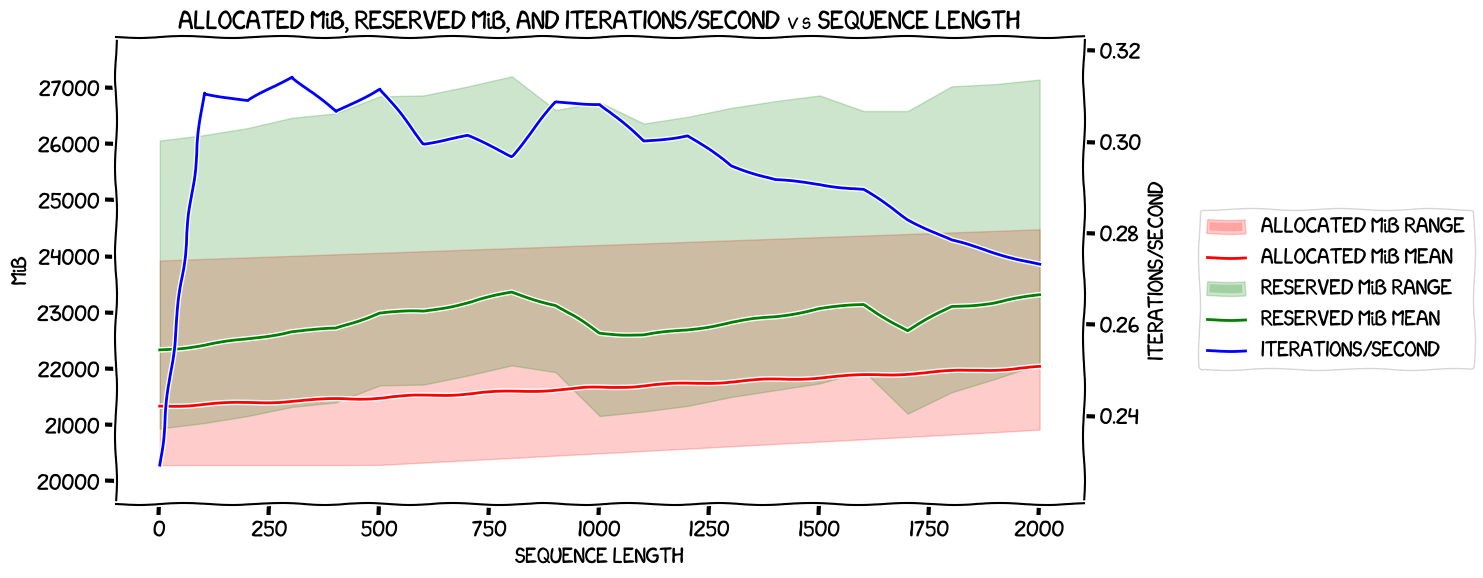

In [26]:
fig = plot(normalized_with_and_optimizer_offload_df)
plt.savefig("/tmp/sequence-length-vs-vram-and-speed-8b-with-expandable-segments-with-optimizer-offload.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

Interesting how the max of the allocated (across all GPUs) overlaps the min of the reserved.

## With optimizer offload: comparisons

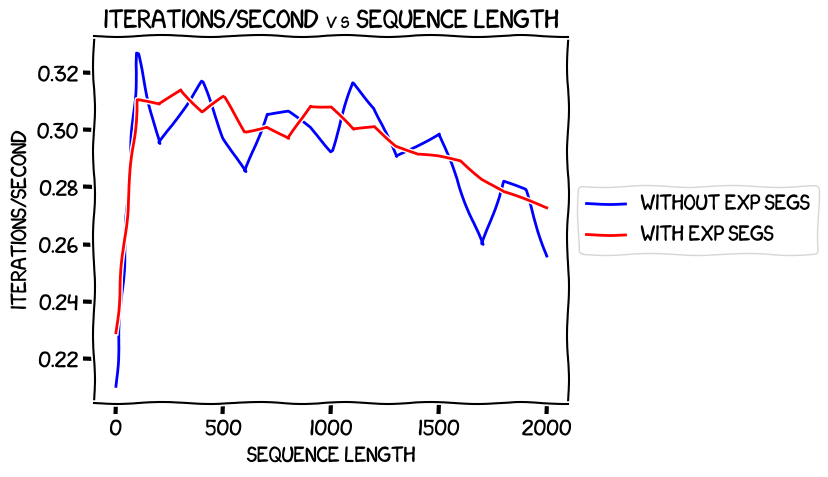

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot iterations/second from both dataframes
ax.plot(normalized_without_and_optimizer_offload_df['Sequence length'], normalized_without_and_optimizer_offload_df['Iterations/second'], 
        label='WITHOUT EXP SEGS', color='blue')
ax.plot(normalized_with_and_optimizer_offload_df['Sequence length'], normalized_with_and_optimizer_offload_df['Iterations/second'], 
        label='WITH EXP SEGS', color='red')

# Set labels and title
ax.set_xlabel('SEQUENCE LENGTH')
ax.set_ylabel('ITERATIONS/SECOND')
ax.set_title('ITERATIONS/SECOND vs SEQUENCE LENGTH')

# Add legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to accommodate legend
plt.savefig("/tmp/sequence-length-vs-iterations-per-second-with-offload-comparison.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

In [28]:
normalized_without_and_optimizer_offload_df

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,...,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second,Allocated MiB Min,Allocated MiB Mean,Allocated MiB Max,Reserved MiB Min,Reserved MiB Mean,Reserved MiB Max
0,1,23929,26934,20419,24752,20419,24752,20419,24752,20419,...,25350,23930,24930,0.210409,20292,21340.500,23930,24752,25121.75,26934
1,101,23929,27154,20465,24972,20465,24972,20465,24972,20465,...,25570,23957,25150,0.327024,20292,21370.625,23957,24972,25397.75,27154
2,201,23929,27282,20512,25100,20512,25100,20512,25100,20512,...,25698,23985,25278,0.295290,20292,21401.500,23985,25100,25525.75,27282
3,301,23930,27344,20559,25162,20558,25162,20559,25162,20559,...,25634,24013,25452,0.306215,20293,21432.375,24013,25162,25586.00,27344
4,401,23929,27518,20605,25336,20605,25336,20605,25336,20605,...,25808,24042,25626,0.317103,20292,21462.625,24042,25336,25760.00,27518
5,501,23929,27690,20652,25508,20652,25508,20652,25508,20652,...,25980,24070,25798,0.297356,20299,21494.375,24070,25508,25876.00,27690
6,601,23929,27910,20695,25728,20695,25728,20695,25728,20695,...,26200,24094,26018,0.285385,20336,21527.000,24094,25728,26096.00,27910
7,701,23929,28088,20744,25906,20744,25906,20744,25906,20744,...,26378,24122,26196,0.305704,20378,21564.000,24122,25906,26274.00,28088
8,801,23929,28262,20788,26080,20788,26080,20788,26080,20788,...,26552,24150,26370,0.306477,20419,21598.500,24150,26080,26448.00,28262
9,901,23929,28450,20835,26268,20835,26268,20835,26268,20835,...,26740,24178,26558,0.300892,20461,21634.625,24178,26268,26636.00,28450


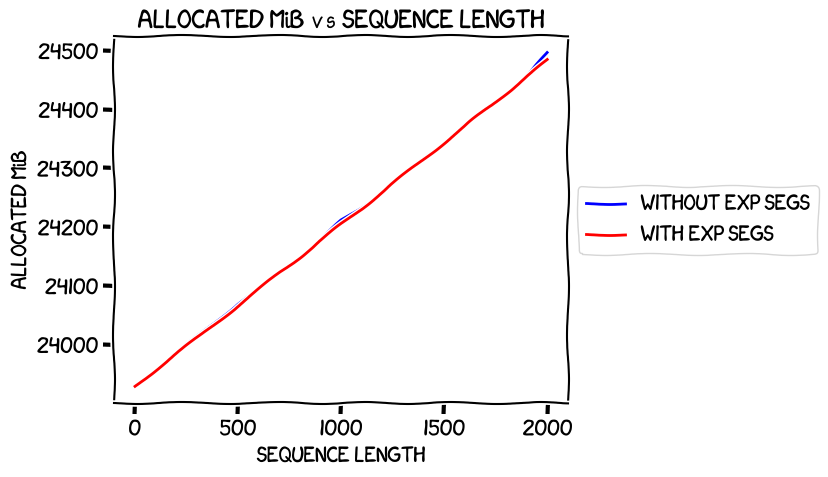

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(normalized_without_and_optimizer_offload_df['Sequence length'], normalized_without_and_optimizer_offload_df['Allocated MiB Max'], 
        label='WITHOUT EXP SEGS', color='blue')
ax.plot(normalized_with_and_optimizer_offload_df['Sequence length'], normalized_with_and_optimizer_offload_df['Allocated MiB Max'], 
        label='WITH EXP SEGS', color='red')

ax.set_xlabel('SEQUENCE LENGTH')
ax.set_ylabel('ALLOCATED MiB')
ax.set_title('ALLOCATED MiB vs SEQUENCE LENGTH')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to accommodate legend
plt.savefig("/tmp/sequence-length-vs-allocated-comparison-with-offload.png", bbox_inches='tight')
plt.show()

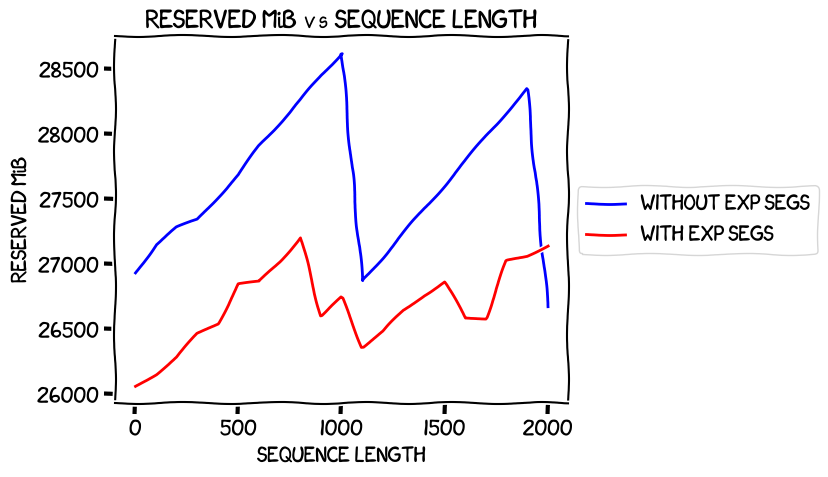

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(normalized_without_and_optimizer_offload_df['Sequence length'], normalized_without_and_optimizer_offload_df['Reserved MiB Max'], 
        label='WITHOUT EXP SEGS', color='blue')
ax.plot(normalized_with_and_optimizer_offload_df['Sequence length'], normalized_with_and_optimizer_offload_df['Reserved MiB Max'], 
        label='WITH EXP SEGS', color='red')

ax.set_xlabel('SEQUENCE LENGTH')
ax.set_ylabel('RESERVED MiB')
ax.set_title('RESERVED MiB vs SEQUENCE LENGTH')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to accommodate legend
plt.savefig("/tmp/sequence-length-vs-reserved-comparison-with-offload.png", bbox_inches='tight')
plt.show()

## Comparing with and without optimizer offload

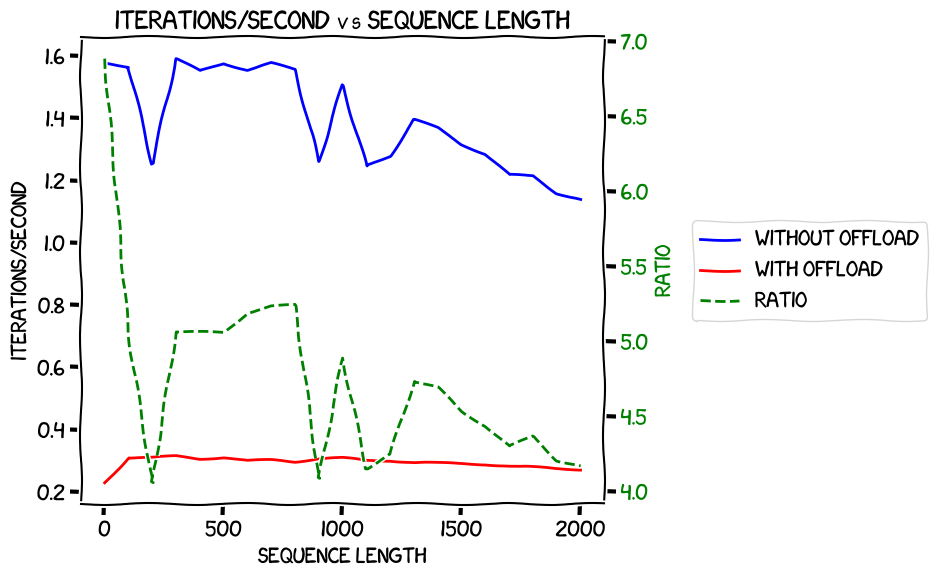

In [34]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot iterations/second from both dataframes on the primary y-axis
ax1.plot(normalized_with_df['Sequence length'], normalized_with_df['Iterations/second'], 
         label='WITHOUT OFFLOAD', color='blue')
ax1.plot(normalized_with_and_optimizer_offload_df['Sequence length'], normalized_with_and_optimizer_offload_df['Iterations/second'], 
         label='WITH OFFLOAD', color='red')

# Set labels for primary y-axis
ax1.set_xlabel('SEQUENCE LENGTH')
ax1.set_ylabel('ITERATIONS/SECOND', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create secondary y-axis
ax2 = ax1.twinx()

# Calculate and plot the ratio on the secondary y-axis
# Note: Division order swapped as per your feedback
ratio = normalized_with_df['Iterations/second'] / normalized_with_and_optimizer_offload_df['Iterations/second']
ax2.plot(normalized_with_df['Sequence length'], ratio, label='RATIO', color='green', linestyle='--')

# Set labels for secondary y-axis
ax2.set_ylabel('RATIO', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Set title
plt.title('ITERATIONS/SECOND vs SEQUENCE LENGTH')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5))

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to accommodate legend
plt.savefig("/tmp/sequence-length-vs-iterations-per-second-with-and-without-offload.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

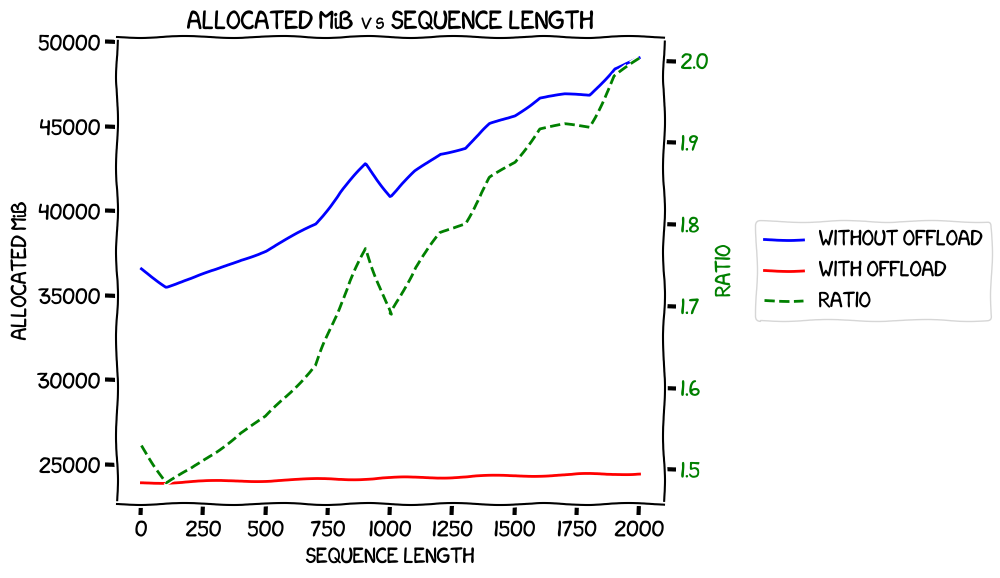

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Allocated MiB Max from both dataframes on the primary y-axis
ax1.plot(normalized_with_df['Sequence length'], normalized_with_df['Allocated MiB Max'], 
         label='WITHOUT OFFLOAD', color='blue')
ax1.plot(normalized_with_and_optimizer_offload_df['Sequence length'], normalized_with_and_optimizer_offload_df['Allocated MiB Max'], 
         label='WITH OFFLOAD', color='red')

# Set labels for primary y-axis
ax1.set_xlabel('SEQUENCE LENGTH')
ax1.set_ylabel('ALLOCATED MiB', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create secondary y-axis
ax2 = ax1.twinx()

# Calculate and plot the ratio on the secondary y-axis
ratio = normalized_with_df['Allocated MiB Max'] / normalized_with_and_optimizer_offload_df['Allocated MiB Max']
ax2.plot(normalized_with_df['Sequence length'], ratio, label='RATIO', color='green', linestyle='--')

# Set labels for secondary y-axis
ax2.set_ylabel('RATIO', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Set title
plt.title('ALLOCATED MiB vs SEQUENCE LENGTH')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5))

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjusted to accommodate legend
plt.savefig("/tmp/sequence-length-vs-allocated-comparison-with-and-without-offload.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

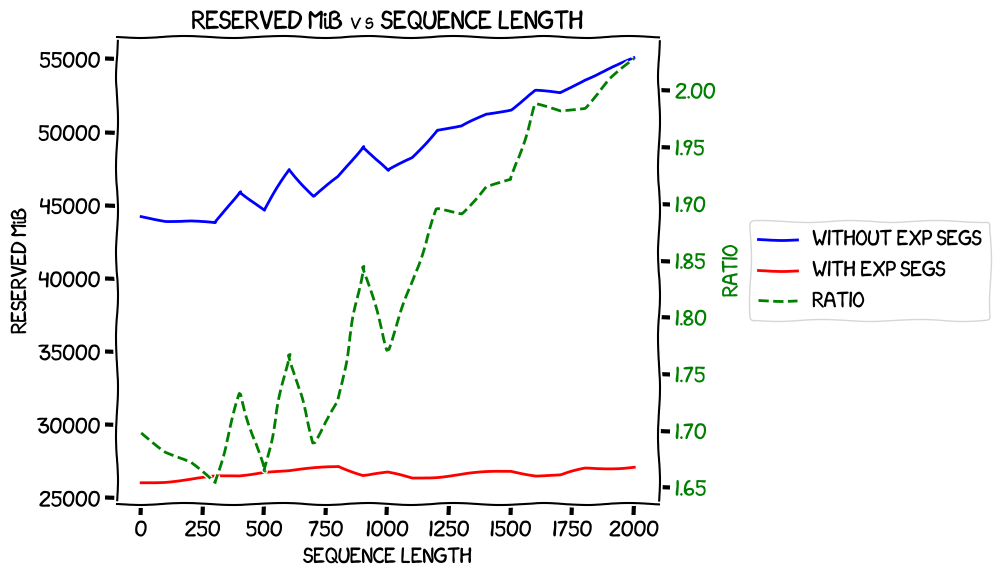

In [33]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Reserved MiB Max from both dataframes on the primary y-axis
ax1.plot(normalized_with_df['Sequence length'], normalized_with_df['Reserved MiB Max'], 
         label='WITHOUT EXP SEGS', color='blue')
ax1.plot(normalized_with_and_optimizer_offload_df['Sequence length'], normalized_with_and_optimizer_offload_df['Reserved MiB Max'], 
         label='WITH EXP SEGS', color='red')

# Set labels for primary y-axis
ax1.set_xlabel('SEQUENCE LENGTH')
ax1.set_ylabel('RESERVED MiB', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create secondary y-axis
ax2 = ax1.twinx()

# Calculate and plot the ratio on the secondary y-axis
ratio = normalized_with_df['Reserved MiB Max'] / normalized_with_and_optimizer_offload_df['Reserved MiB Max']
ax2.plot(normalized_with_df['Sequence length'], ratio, label='RATIO', color='green', linestyle='--')

# Set labels for secondary y-axis
ax2.set_ylabel('RATIO', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Set title (unchanged)
ax1.set_title('RESERVED MiB vs SEQUENCE LENGTH')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5))

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjusted to accommodate legend
plt.savefig("/tmp/sequence-length-vs-reserved-comparison-with-and-without-offload.png", bbox_inches='tight', pad_inches=0.1)
plt.show()